<a href="https://www.kaggle.com/code/hoshimmardonov1/diagnosis-of-diabetes?scriptVersionId=125520798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import jaccard_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,classification_report

import seaborn as sns
import matplotlib.pyplot as plt

<h1 style="padding:30px; color: green; background-color:gray; display:inline-block">Diagnosis of diabetes.</h1>

The following dataset is from the National Institute of Diabetes and Kidney Diseases, India. 

**The goal** is to predict whether a patient has diabetes based on diagnostic measurements.

In [2]:
URL = "https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/diabetes.csv"
df = pd.read_csv(URL)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Content
All patients in the dataset are women at least 21 years old.

Columns:
*  Pregnancies: the number of pregnancies
* Glucose: Glucose test result
* BloodPressure: diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skinfold thickness (mm)
* Insulin: 2-hour serum insulin (mu U/ml)
* BMI: Body Mass Index (weight in kg / (height in m) ^ 2)
* DiabetesPedigreeFunction: Diabetes Pedigree Function
* Age: Age (years)
* Outcome: Class (0 - no diabetes, 1 - diabetes)

The dataset included information on the presence or absence of diabetes. And the **Outcome** column represents diabetes *(1)* or no diabetes *(0)*.

In [3]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

So we have **268 patients** with *diabetes* and **500** without *it*. To ensure balance, we will exclude **268 non-diabetic** subjects.

In [4]:
df0 = df[df['Outcome'] == 0].sample(268)
df1 = df[df['Outcome'] == 1]
df_norm = pd.concat([df1, df0], axis=0)
df_norm['Outcome'].value_counts()

1    268
0    268
Name: Outcome, dtype: int64

<h1 style="padding:30px; color: black; background-color:green; display:inline-block">Correlation.</h1>

In [5]:
corr_matrix = df_norm.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.117225,0.126912,0.084607,0.061269,0.023895,0.038955,0.528903,0.241023
Glucose,0.117225,1.000000,0.138811,0.049244,0.321118,0.199049,0.155489,0.273832,0.453029
BloodPressure,0.126912,0.138811,1.000000,0.229765,0.095914,0.273509,0.073219,0.253342,0.084207
SkinThickness,0.084607,0.049244,0.229765,1.000000,0.450878,0.359061,0.226550,0.114916,0.090028
Insulin,0.061269,0.321118,0.095914,0.450878,1.000000,0.165259,0.178347,0.009652,0.104808
BMI,0.023895,0.199049,0.273509,0.359061,0.165259,1.000000,0.160542,0.025923,0.312969
DiabetesPedigreeFunction,0.038955,0.155489,0.073219,0.226550,0.178347,0.160542,1.000000,0.036440,0.167047
Age,0.528903,0.273832,0.253342,0.114916,0.009652,0.025923,0.036440,1.000000,0.243611
Outcome,0.241023,0.453029,0.084207,0.090028,0.104808,0.312969,0.167047,0.243611,1.000000


In [6]:
df_norm["Pregnancies/Age"] = df_norm["Pregnancies"] / df_norm["Age"]
df_norm["Blood/Age"] = df_norm["BloodPressure"] / df_norm["Age"]
df_norm["Glucose/Age"] = df_norm["Glucose"] / df_norm["Age"]

In [7]:
df_norm.corrwith(df_norm['Outcome']).abs().sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.453029
BMI                         0.312969
Age                         0.243611
Pregnancies                 0.241023
Pregnancies/Age             0.187036
Blood/Age                   0.185860
DiabetesPedigreeFunction    0.167047
Insulin                     0.104808
Glucose/Age                 0.096880
SkinThickness               0.090028
BloodPressure               0.084207
dtype: float64

<h1 style="padding:30px; color: black; background-color:green; display:inline-block">Machine Learning.</h1>

In [8]:
X = df_norm.drop('Outcome', axis=1).values
y = df_norm['Outcome']
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)

# k-NN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=17) # k-ni qiymati

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [10]:
y_predict = knn.predict(X_test)

<h1 style="padding:30px; color: black; background-color:green; display:inline-block">Evaluation.</h1>
<h3>Jaccard index</h3>

In [11]:
jaccard_score(y_test, y_predict)

0.5606060606060606

<h3>Confusion matrix</h3>

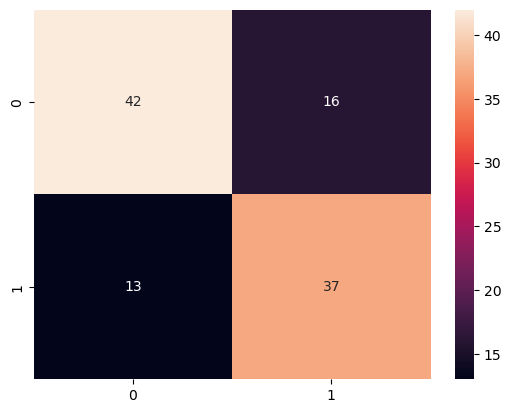

In [12]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [13]:
confusion_matrix(y_test, y_predict)

array([[42, 16],
       [13, 37]])

Precision, recall, F1

In [14]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        58
           1       0.70      0.74      0.72        50

    accuracy                           0.73       108
   macro avg       0.73      0.73      0.73       108
weighted avg       0.73      0.73      0.73       108



We check using cross-validation

In [15]:
predict = cross_val_predict(estimator = knn, X = X, y = y, cv = 5)

# Modelni baholash
from sklearn.metrics import classification_report
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.71      0.71       268
           1       0.71      0.72      0.72       268

    accuracy                           0.71       536
   macro avg       0.71      0.71      0.71       536
weighted avg       0.71      0.71      0.71       536



Finding the best k

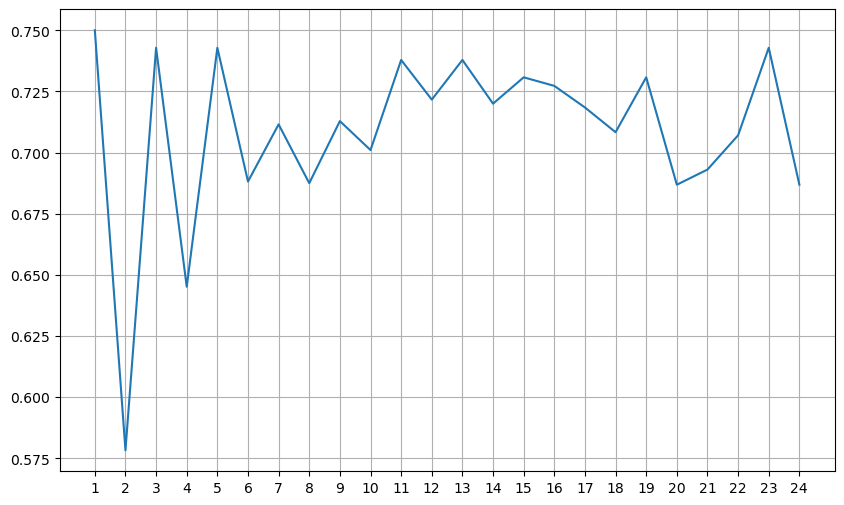

In [16]:
f1 = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k) # k-ni qiymati
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    f1.append(f1_score(y_test, y_predict))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),f1)
plt.xticks(range(1,25))
plt.grid()
plt.show()

Grid Search

In [17]:
param_grid = {'n_neighbors': np.arange(1, 25)}

knn_gscv = GridSearchCV(knn, param_grid, cv=5)

knn_gscv.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=24),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [18]:
knn_gscv.cv_results_['rank_test_score']

array([23, 24, 21, 22, 20, 18, 14,  9,  6,  3,  1,  2,  4,  7, 15, 13, 19,
       16, 12, 17,  8, 10,  5, 11], dtype=int32)

In [19]:
knn_gscv.best_params_

{'n_neighbors': 11}

In [20]:
knn_gscv.best_score_

0.742557978539287

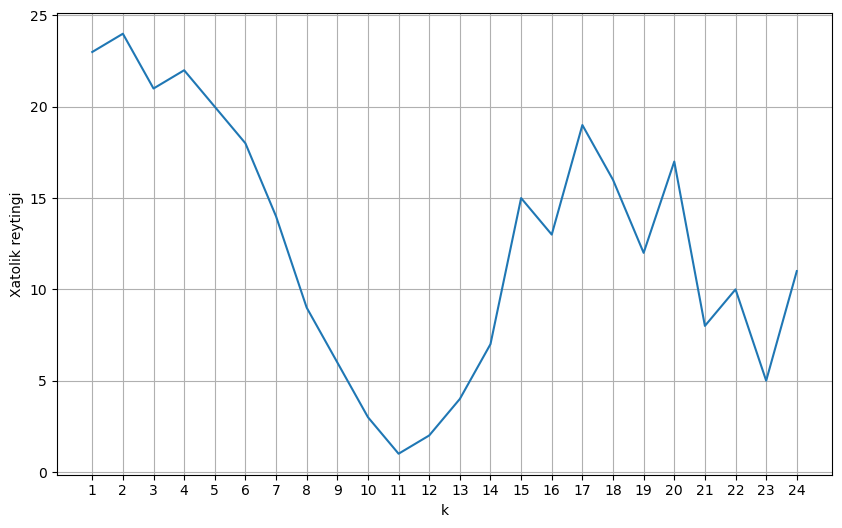

In [21]:
plt.figure(figsize=(10,6))
plt.plot(param_grid['n_neighbors'], knn_gscv.cv_results_['rank_test_score'])
plt.xticks(param_grid['n_neighbors'])
plt.xlabel("k")
plt.ylabel("Xatolik reytingi")
plt.grid()
plt.show()